# Analysis Google Play Apps Data

In [ ]:
# Google App Data Analysis
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

In [3]:
# Reading data frame
df_app = pd.read_csv('googleplaystore2.csv')
df_app.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,"U Launcher Lite ?€? FREE Live Cool Themes, Hid...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


In [4]:
print("The Google play store dataset contains %d rows and %d columns." %(df_app.shape[0], df_app.shape[1]))

The Google play store dataset contains 10840 rows and 13 columns.


In [5]:
# Drpping Data frame which has NaN values
df_app = df_app.dropna()
print("The Google play store dataset contains %d rows and %d columns." %(df_app.shape[0], df_app.shape[1]))

The Google play store dataset contains 9360 rows and 13 columns.


In [6]:
# Checking if there are any duplicates rows present in dataset that has same App
# False = No duplicate
# True = Duplicate
df_app.duplicated(subset='App').value_counts()

False    8190
True     1170
dtype: int64

In [7]:
#Dropping the duplicates
df_app=df_app.drop_duplicates(subset='App')

In [8]:
print("The Google play store dataset contains %d rows and %d columns after dropping NAN and duplicates." %(df_app.shape[0],df_app.shape[1]))


The Google play store dataset contains 8190 rows and 13 columns after dropping NAN and duplicates.


In [9]:
df_app.dtypes

App                object
Category           object
Rating            float64
Reviews             int64
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [10]:
#Converting the Installs column into integer
#Removes '+' from Installs
df_app['Installs'] = df_app['Installs'].apply(lambda a:a.split('+')[0])
#Removes ',' from Installs
se = df_app['Installs'].apply(lambda a:a.split(','))


def add_list(x):
    sum=''
    for i in range(0, len(x)):
        sum+=x[i]
    return int(sum)

#Convert str to int values
df_app['Installs'] = se.apply(lambda a:add_list(a))
df_app.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,"U Launcher Lite ?€? FREE Live Cool Themes, Hid...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


In [11]:
#Reomving currency symbol from the price and making it float
def remove_curr(x):
    if x != '0':
        x=x.split('$')[1]
    return float(x)

#Remove '$' from price
df_app['Price'] = df_app['Price'].apply(lambda a:remove_curr(a))
df_app.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0.0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0.0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,"U Launcher Lite ?€? FREE Live Cool Themes, Hid...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0.0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0.0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0.0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


In [12]:
#Checking the number of apps that avaiable based on type: Free vs Paid
df_app['Type'].value_counts()

Free    7588
Paid     602
Name: Type, dtype: int64

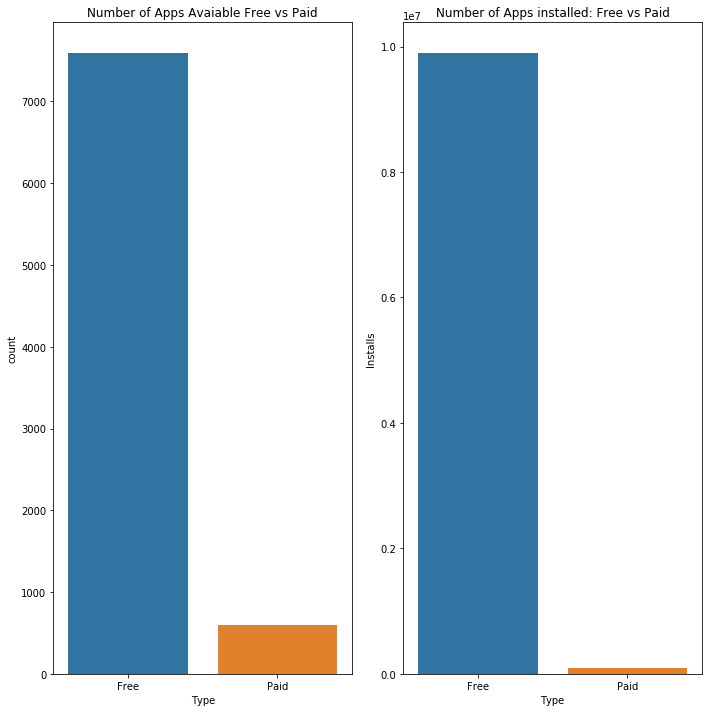

In [13]:
#Number of free and paid apps avaiable
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
sns.countplot(x='Type', data=df_app)
plt.title('Number of Apps Avaiable Free vs Paid')

#Most installed apps based on Category
plt.subplot(1,2,2)
sns.barplot(x='Type', y='Installs', data=df_app, ci=None)
plt.title('Number of Apps installed: Free vs Paid')
plt.tight_layout()

Text(0.5,1,'Number of Apps available based on Category')

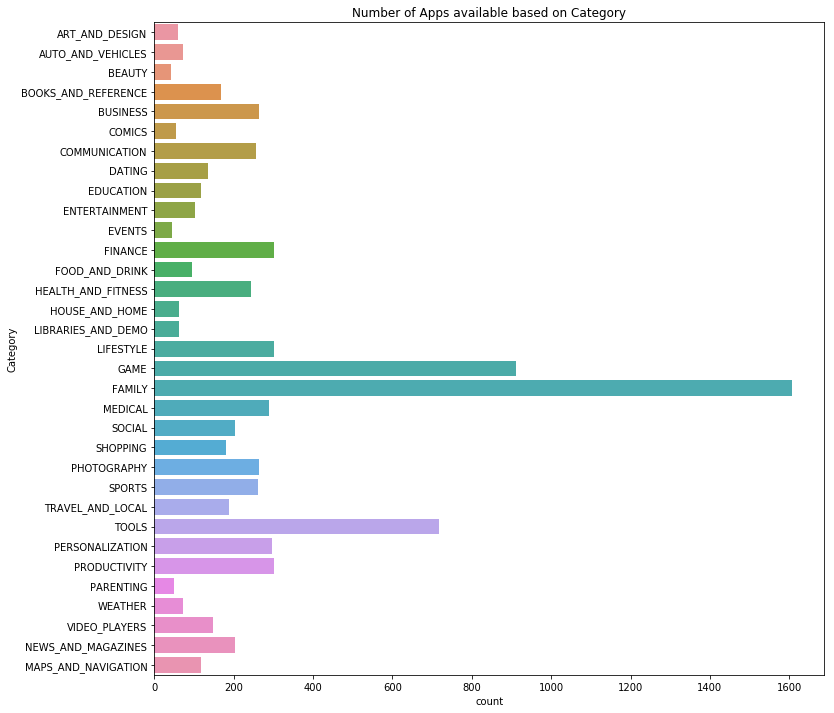

In [14]:
#Checking the number of Apps avaiable on playstore based on category
plt.figure(figsize=(12,12))
sns.countplot(y='Category', data=df_app)
plt.title('Number of Apps available based on Category')

Text(0.5,1,'Number of Apps installed based on Category')

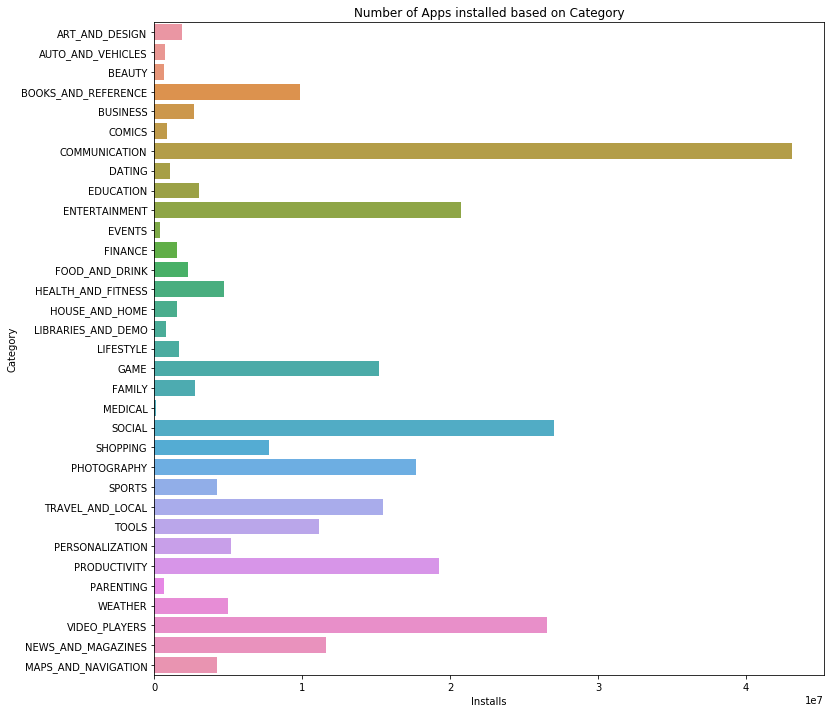

In [15]:
#Most installed apps based on Category
plt.figure(figsize=(12,12))
sns.barplot(x='Installs', y='Category', data = df_app, ci = None)
plt.title("Number of Apps installed based on Category")

Text(0.5,1,'Number of Apps avaiable based on Content Rating')

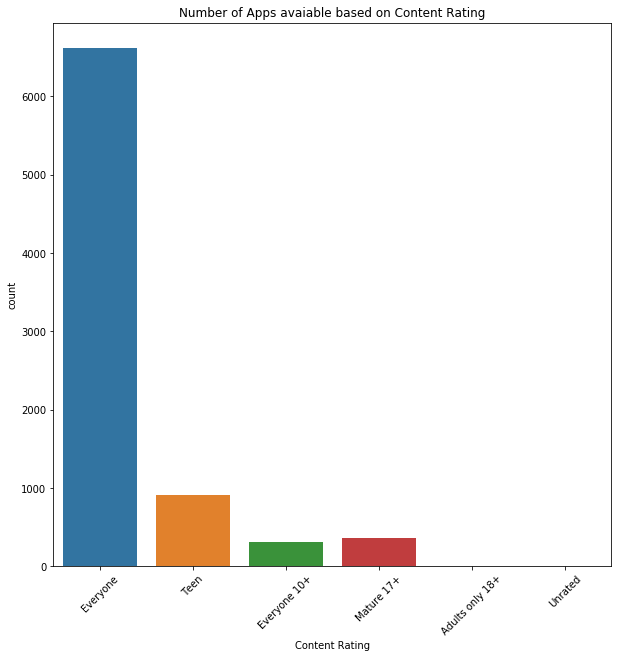

In [16]:
# Apps avaiable based on Content rating
plt.figure(figsize=(10, 10))
sns.countplot(x='Content Rating', data = df_app)
plt.xticks(rotation=45)
plt.title("Number of Apps avaiable based on Content Rating")

Text(0.5,1,'Number of Apps installed based on Content rating')

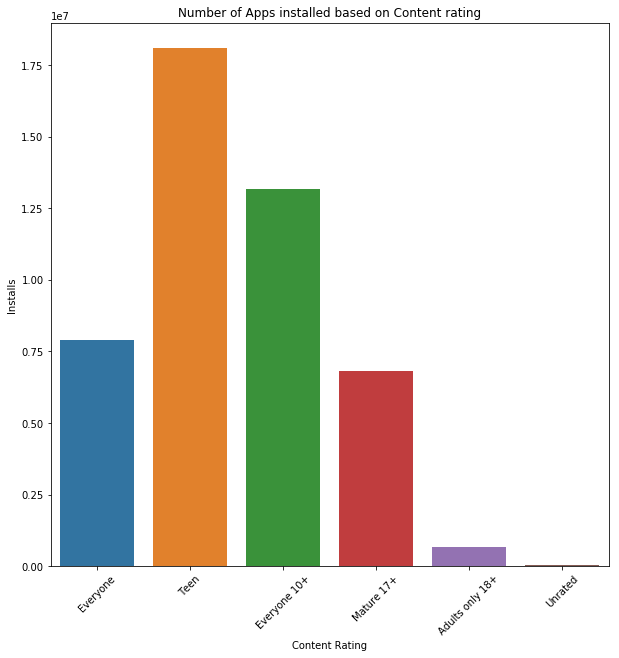

In [17]:
# Apps installed based on Content rating
plt.figure(figsize=(10,10))
sns.barplot(x='Content Rating', y='Installs', data = df_app, ci=None)
plt.xticks(rotation=45)
plt.title('Number of Apps installed based on Content rating')

Text(0.5,1,"Android Version's available")

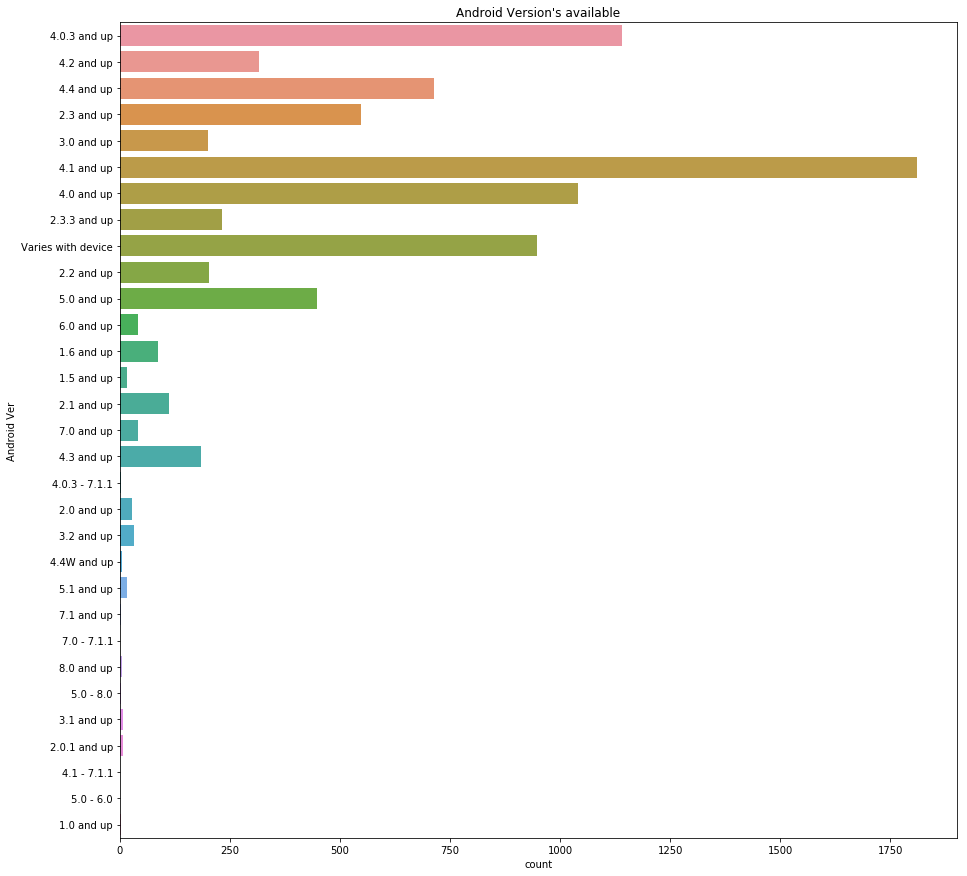

In [18]:
# Android Version of the most avaiable apps
plt.figure(figsize=(15,15))
sns.countplot(y='Android Ver', data = df_app)
plt.title("Android Version's available")

Text(0.5,1,'Android Version of installed Apps')

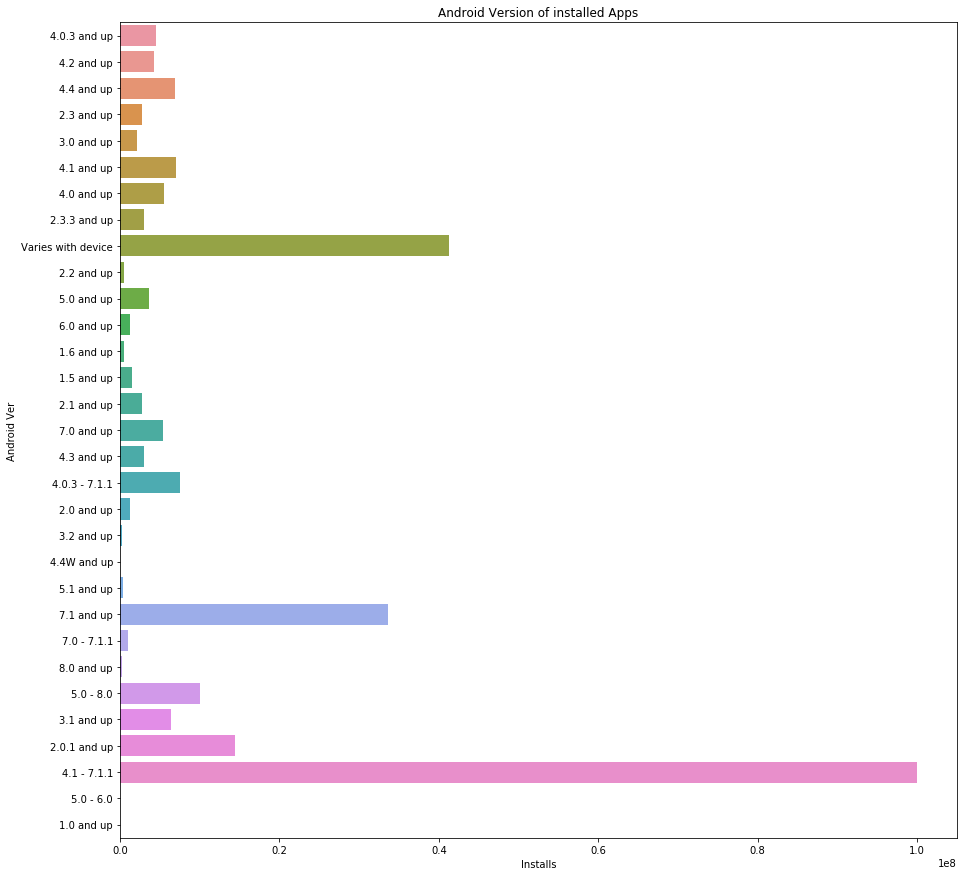

In [19]:
#Android version of most installed apps
plt.figure(figsize=(15,15))
sns.barplot(x="Installs", y="Android Ver", data = df_app, ci = None)
plt.title("Android Version of installed Apps")

Text(0.5,1,'Number of Apps and ratings')

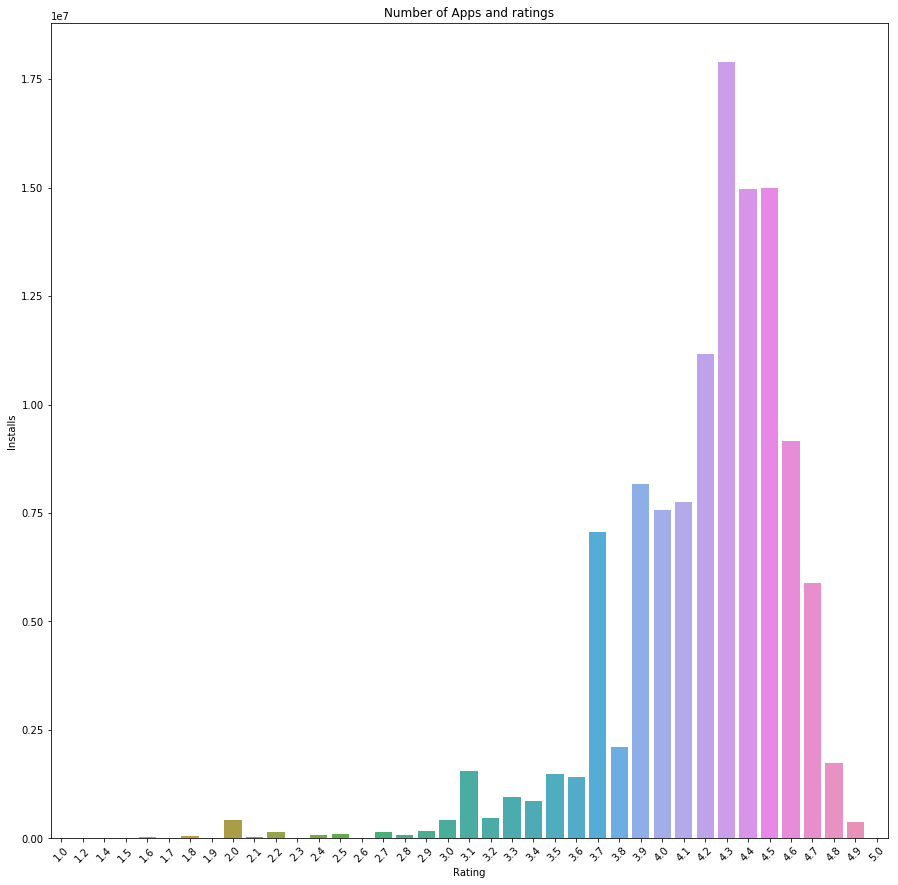

In [20]:
#Rating of Apps and the number of installed
plt.figure(figsize=(15,15))
sns.barplot(y='Installs', x='Rating', data = df_app, ci = None)
plt.xticks(rotation=45)
plt.title("Number of Apps and ratings")

In [21]:
# Most download Paid apps
df_type = df_app[df_app['Type'] == 'Paid']
df_type.sort_values(by = 'Installs', ascending=False)['App'].head(20)

2241                                             Minecraft
4034                                         Hitman Sniper
9165     League of Stickman 2018- Ninja Arena PVP(Dream...
2242                            Card Wars - Adventure Time
9151                               Lost Journey (Dreamsky)
3405                                            HD Widgets
3403                                 Beautiful Widgets Pro
5631                               Five Nights at Freddy's
6675                                  Infinity Dungeon VIP
5578                               Sleep as Android Unlock
5490                                            True Skate
2883                                   Facetune - For Free
9941                                                Tasker
4260                                     Cut the Rope GOLD
8860                                           Bloons TD 5
8804                                   DraStic DS Emulator
7355                                               Three

In [22]:
# Top 20 apps that are installed most in Category Communication
df_com = df_app[df_app['Category'] == 'COMMUNICATION']
df_com.sort_values(by='Installs', ascending = False)['App'].head(20)

335            Messenger ?€? Text and Video Chat for Free
391                         Skype - free IM & video calls
338                          Google Chrome: Fast & Secure
340                                                 Gmail
341                                              Hangouts
336                                    WhatsApp Messenger
347                         imo free video calls and chat
378           UC Browser - Fast Download Private & Secure
371                 Google Duo - High Quality Video Calls
403                           LINE: Free Calls & Messages
342                                       Viber Messenger
345                         Yahoo Mail ?€? Stay Organized
449     Truecaller: Caller ID, SMS spam blocking & Dialer
4279                                                  Kik
406                           BBM - Free Calls & Messages
407                          KakaoTalk: Free Calls & Text
395            GO SMS Pro - Messenger, Free Themes, Emoji
339           

In [23]:
# Top 20 apps that are installed most in Category Social
df_soc = df_app[df_app['Category']=='SOCIAL']
df_soc.sort_values(by='Installs', ascending = False)['App'].head(20)

2544                                  Facebook
2554                                   Google+
2545                                 Instagram
2546                             Facebook Lite
2550                                  Snapchat
2588            Badoo - Free Chat & Dating App
2582                                  LinkedIn
6373                                        VK
2592              Tango - Live Video Broadcast
3951                   BIGO LIVE - Live Stream
3945            Tik Tok - including musical.ly
2552                                 Pinterest
2548                                    Tumblr
2595    ooVoo Video Calls, Messaging & Stories
2593            MeetMe: Chat & Meet New People
2636                   Zello PTT Walkie Talkie
2629                       POF Free Dating App
2614               SKOUT - Meet, Chat, Go Live
2580                        Kate Mobile for VK
2578                    Periscope - Live Video
Name: App, dtype: object

## Machine Learning Modelling

In [83]:
#Spliting X and y
rating = df_app['Rating']
ratingE = rating ** 2
features_raw = df_app.drop(['Rating','App','Genres', 'Last Updated', 'Current Ver', 'Android Ver','Size'],axis = 1)
features_raw.head(5)

,Category,Reviews,Installs,Type,Price,Content Rating
0,ART_AND_DESIGN,159,10000,Free,0.0,Everyone
1,ART_AND_DESIGN,967,500000,Free,0.0,Everyone
2,ART_AND_DESIGN,87510,5000000,Free,0.0,Everyone
3,ART_AND_DESIGN,215644,50000000,Free,0.0,Teen
4,ART_AND_DESIGN,967,100000,Free,0.0,Everyone


In [84]:
# # Remove "M" in Size and multiply 1024
# def change_size(size):
#     if 'M' in size:
#         x = size[:-1]
#         x = float(x)*1024
#         return(x)
#     elif 'k' == size[-1:]:
#         x = size[:-1]
#         return(x)
#     else:
#         return None

# features_raw["Size"] = float(features_raw["Size"].map(change_size)
# features_raw.Size.fillna(method = 'ffill', inplace = True)
# features_raw.dtypes

Text(0.5,1,'Installs Distribution')

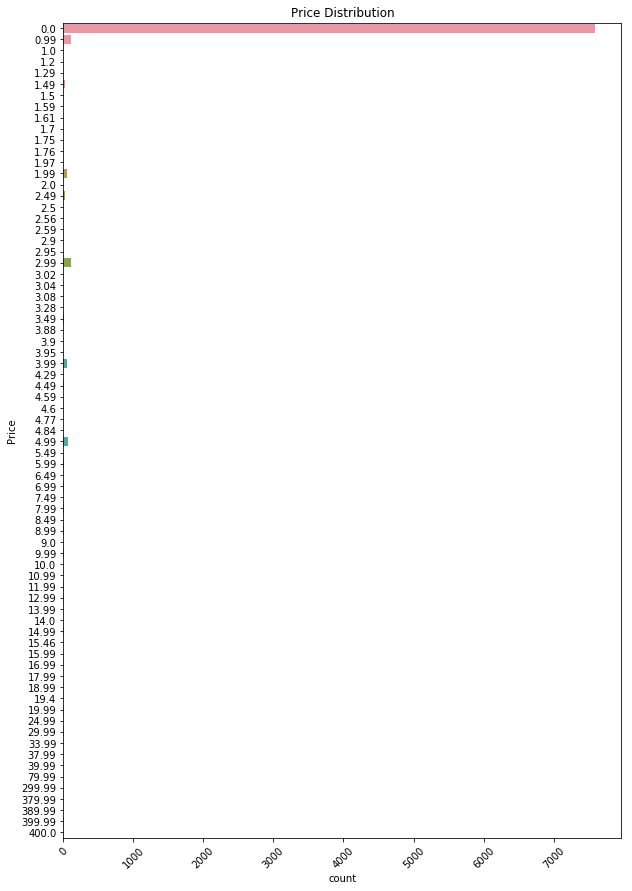

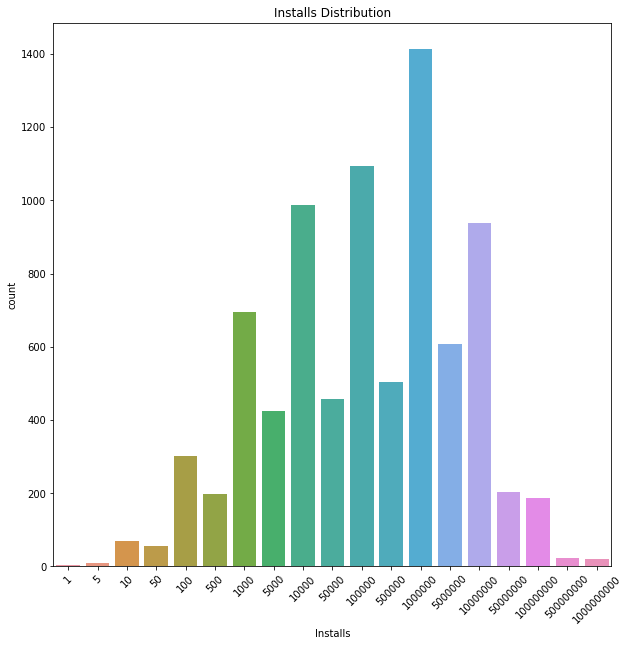

In [85]:
# Visualize skewed countinous features of original data
plt.figure(figsize=(10, 15))
sns.countplot(y='Price', data = features_raw)
plt.xticks(rotation=45)
plt.title("Price Distribution")

plt.figure(figsize=(10, 10))
sns.countplot(x='Installs', data = features_raw)
plt.xticks(rotation=45)
plt.title("Installs Distribution")


Text(0.5,1,'Installs Distribution')

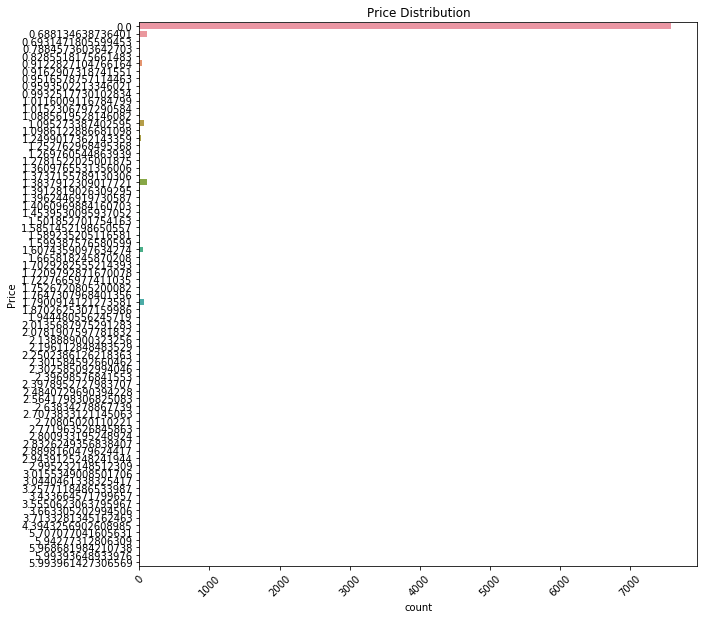

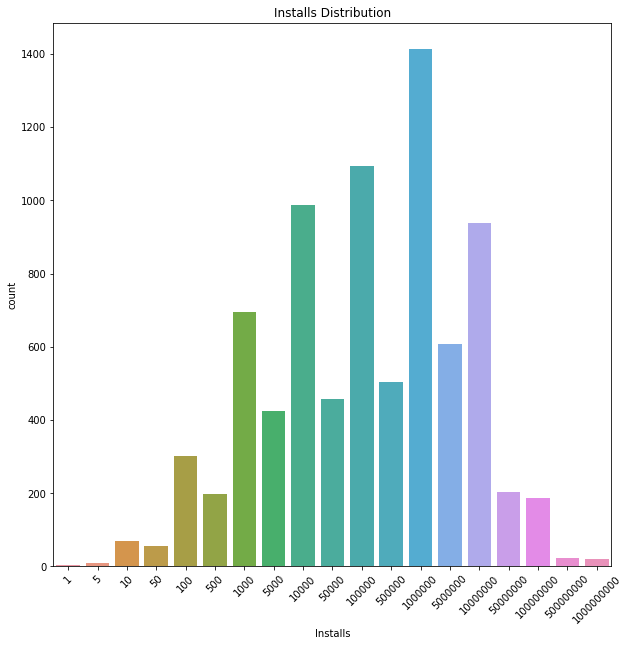

In [86]:
# Log-transform the skewed features
skewed = ['Reviews', 'Price']
features_transformed = pd.DataFrame(data = features_raw)
features_transformed[skewed] = features_raw[skewed].apply(lambda x:np.log(x + 1))


plt.figure(figsize=(10, 10))
sns.countplot(y='Price', data = features_transformed)
plt.xticks(rotation=45)
plt.title("Price Distribution")

plt.figure(figsize=(10, 10))
sns.countplot(x='Installs', data = features_transformed)
plt.xticks(rotation=45)
plt.title("Installs Distribution")

#plt.figure(figsize=(10, 10))
#sns.countplot(x='Reviews', data = features_transformed)
#plt.xticks(rotation=45)
#plt.title("Reviews Distribution")

In [87]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical = ['Installs' , 'Reviews', 'Price']

features_log_minmax_transform = pd.DataFrame(data = features_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

c:\Users\hello\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Category,Reviews,Installs,Type,Price,Content Rating
0,ART_AND_DESIGN,0.250672,0.00001,Free,0.0,Everyone
1,ART_AND_DESIGN,0.353644,0.00050,Free,0.0,Everyone
2,ART_AND_DESIGN,0.611310,0.00500,Free,0.0,Everyone
3,ART_AND_DESIGN,0.662901,0.05000,Free,0.0,Teen
4,ART_AND_DESIGN,0.353644,0.00010,Free,0.0,Everyone


In [88]:

features_final = pd.get_dummies(features_log_minmax_transform)
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))
# print (encoded)
#print(features_final.head(5))

44 total features after one-hot encoding.


In [89]:
#for evaluation of error term and 
def Evaluationmatrix(y_true, y_predict):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_true,y_predict)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_true,y_predict)))
    #print ('Mean squared Log Error: '+ str(metrics.mean_squared_log_error(y_true,y_predict)))

In [90]:
#to add into results_index for evaluation of error term 
def Evaluationmatrix_dict(y_true, y_predict, name = 'Linear - Integer'):
    dict_matrix = {}
    dict_matrix['Series Name'] = name
    dict_matrix['Mean Squared Error'] = metrics.mean_squared_error(y_true,y_predict)
    dict_matrix['Mean Absolute Error'] = metrics.mean_absolute_error(y_true,y_predict)
    #dict_matrix['Mean Squared Log Error'] = metrics.mean_squared_log_error(y_true,y_predict)
    return dict_matrix

In [91]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    ratingE, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 5733 samples.
Testing set has 2457 samples.


In [92]:
# from sklearn.linear_model import LinearRegression
# from sklearn import linear_model
# from sklearn import metrics

# reg = LinearRegression().fit(X_train, y_train)
# print(reg.score(features_final, rating))
# regResults = reg.predict(X_test)

# #Creation of results dataframe and addition of first entry
# resultsdf = pd.DataFrame()
# resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,regResults, name = 'Linear - Dummy'),ignore_index = True)

# plt.figure(figsize=(12,7))
# # sns.regplot(Results,y_test,color='teal', label = 'Integer', marker = 'x')
# sns.regplot(resultsdf,y_test,color='orange',label = 'Dummy')
# plt.legend()
# plt.title('Linear model - Excluding Genres')
# plt.xlabel('Predicted Ratings')
# plt.ylabel('Actual Ratings')
# plt.show()

# # regRidge = linear_model.Ridge(alpha = .5)
# # regRidge = regRidge.fit(features_final, rating)
# # print(regRidge.score(features_final, rating))

# # regRidgeCV = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0], cv=3)
# # regRidgeCV = regRidgeCV.fit(features_final, rating)
# # print(regRidgeCV.score(features_final, rating))


In [130]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron

reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
regResults = reg.predict(X_test)

llReg = linear_model.LassoLars(alpha=.1)
llReg.fit(X_train, y_train)
llRegResults = llReg.predict(X_test)


ridgeReg = linear_model.Ridge (alpha = .5)
ridgeReg.fit (X_train, y_train) 
ridgeRegResults = ridgeReg.predict(X_test)


lassoReg = linear_model.Lasso(alpha = 0.1)
lassoReg.fit(X_train, y_train)
lassoRegResults = lassoReg.predict(X_test)

bayesianRidgeReg = linear_model.BayesianRidge()
bayesianRidgeReg.fit(X_train, y_train)
bayesianRidgeRegResults = bayesianRidgeReg.predict(X_test)


poly = PolynomialFeatures(degree=2)
poly.fit_transform(X_train)

plReg = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression(fit_intercept=False))])
plReg = plReg.fit(X_train, y_train)
plRegResults = plReg.predict(X_test)

regScoreAll = reg.score(features_final, rating)
regScoreTrain = reg.score(X_train, y_train)
regScoreTest = reg.score(X_test, regResults)

llScoreAll = llReg.score(features_final, rating)
llScoreTrain = llReg.score(X_train, y_train)
llScoreTest = llReg.score(X_test, llRegResults)

ridgeScoreAll = ridgeReg.score(features_final, rating)
ridgeScoreTrain = ridgeReg.score(X_train, y_train)
ridgeScoreTest = ridgeReg.score(X_test, ridgeRegResults)

lassoScoreAll = lassoReg.score(features_final, rating)
lassoScoreTrain = lassoReg.score(X_train, y_train)
lassoScoreTest = lassoReg.score(X_test, lassoRegResults)

bayesianRidgeScoreAll = bayesianRidgeReg.score(features_final, rating)
bayesianRidgeScoreTrain = bayesianRidgeReg.score(X_train, y_train)
bayesianRidgeScoreTest = bayesianRidgeReg.score(X_test, bayesianRidgeRegResults)

plScoreAll = plReg.score(features_final, rating)
plScoreTrain = plReg.score(X_train, y_train)
plScoreTest = plReg.score(X_test, plRegResults)


print("Linear Regression Score(R^2) with all the data: {}.".format(regScoreAll))
print("Linear Regression Score(R^2) with training data: {}.".format(regScoreTrain))
print("Linear Regression Score(R^2) with testing data: {}.".format(regScoreTest))
print('\n')
print("LARS Lasso Regression Score(R^2) with all the data: {}.".format(llScoreAll))
print("LARS Lasso Regression Score(R^2) with training data: {}.".format(llScoreTrain))
print("LARS Lasso Regression Score(R^2) with testing data: {}.".format(llScoreTest))
print('\n')
print("Ridge Regression Score(R^2) with all the data: {}.".format(ridgeScoreAll))
print("Ridge Regression Score(R^2) with training data: {}.".format(ridgeScoreTrain))
print("Ridge Regression Score(R^2) with testing data: {}.".format(lassoScoreTest))
print('\n')
print("Lasso Regression Score(R^2) with all the data: {}.".format(bayesianRidgeScoreAll))
print("Lasso Regression Score(R^2) with training data: {}.".format(bayesianRidgeScoreTrain))
print("Lasso Regression Score(R^2) with testing data: {}.".format(bayesianRidgeScoreTest))
print('\n')
print("Bayesian Ridge Regression Score(R^2) with all the data: {}.".format(plScoreAll))
print("Bayesian Ridge Regression Score(R^2) with training data: {}.".format(plScoreTrain))
print("Bayesian Ridge Regression Score(R^2) with testing data: {}.".format(plScoreTest))
print('\n')
print("Polynomial Regression Score(R^2) with all the data: {}.".format(plScoreAll))
print("Polynomial Ridge Regression Score(R^2) with training data: {}.".format(plScoreTrain))
print("Polynomial Ridge Regression Score(R^2) with testing data: {}.".format(plScoreTest))




# plFeatures = pd.DataFrame(plReg.transform(X_train), columns=plReg.get_feature_names(X_train.columns))
# print (plFeatures)
print('\n')
print("The number of polynomial coefficient combinations are: {}.".format(len(plReg.named_steps['linear'].coef_)))

# print('\n')
# print("Linear Regression coefficients:")
# print('\n')
# print(reg.coef_)
# print("Linear Regression independent term: {}.".format(reg.intercept_))



# plFeatures = pd.DataFrame(reg.coef_, columns=X_train.columns)
# print (plFeatures)

Linear Regression Score(R^2) with all the data: -639.9370397389317.
Linear Regression Score(R^2) with training data: 0.0574652445603906.
Linear Regression Score(R^2) with testing data: 1.0.


LARS Lasso Regression Score(R^2) with all the data: -637.7081115091911.
LARS Lasso Regression Score(R^2) with training data: 0.0.
LARS Lasso Regression Score(R^2) with testing data: 1.0.


Ridge Regression Score(R^2) with all the data: -639.9556611593803.
Ridge Regression Score(R^2) with training data: 0.05746100207786442.
Ridge Regression Score(R^2) with testing data: 1.0.


Lasso Regression Score(R^2) with all the data: -639.4396756260863.
Lasso Regression Score(R^2) with training data: 0.05587170382112483.
Lasso Regression Score(R^2) with testing data: 1.0.


Bayesian Ridge Regression Score(R^2) with all the data: -4.2205798455191036e+19.
Bayesian Ridge Regression Score(R^2) with training data: 0.13537768953091356.
Bayesian Ridge Regression Score(R^2) with testing data: 1.0.


Polynomial Regres

Text(0.5,1,'Polynomial Regression R^2')

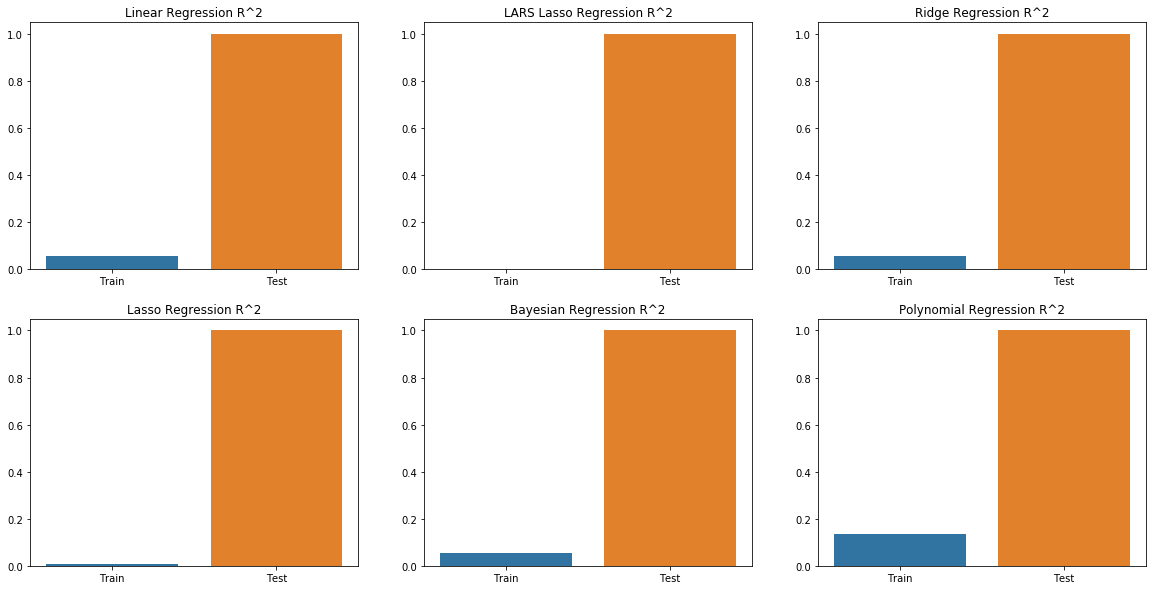

In [94]:
# sns.set(style="white", context="talk")
rs = np.random.RandomState(8)

# Set up the matplotlib figure

regScores = [ regScoreTrain, regScoreTest]

llScores = [ llScoreTrain, llScoreTest]

ridgeScores = [ ridgeScoreTrain, ridgeScoreTest]

lassoScores = [ lassoScoreTrain, lassoScoreTest]

bayesianRidgeScores = [ bayesianRidgeScoreTrain, bayesianRidgeScoreTest]

plScores = [ plScoreTrain, plScoreTest]

plt.figure(figsize = (20,10))
x = ['Train','Test']

plt.subplot(2,3,1)
sns.barplot(x=x, y=regScores, ci=None)
plt.title("Linear Regression R^2")

plt.subplot(2,3,2)
sns.barplot(x=x, y=llScores, ci=None)
plt.title("LARS Lasso Regression R^2")

plt.subplot(2,3,3)
sns.barplot(x=x, y=ridgeScores, ci=None)
plt.title("Ridge Regression R^2")

plt.subplot(2,3,4)
sns.barplot(x=x, y=lassoScores, ci=None)
plt.title("Lasso Regression R^2")

plt.subplot(2,3,5)
sns.barplot(x=x, y=bayesianRidgeScores, ci=None)
plt.title("Bayesian Regression R^2")

plt.subplot(2,3,6)
sns.barplot(x=x, y=plScores, ci=None)
plt.title("Polynomial Regression R^2")


Text(0.5,1,'Linear Regression coefficients')

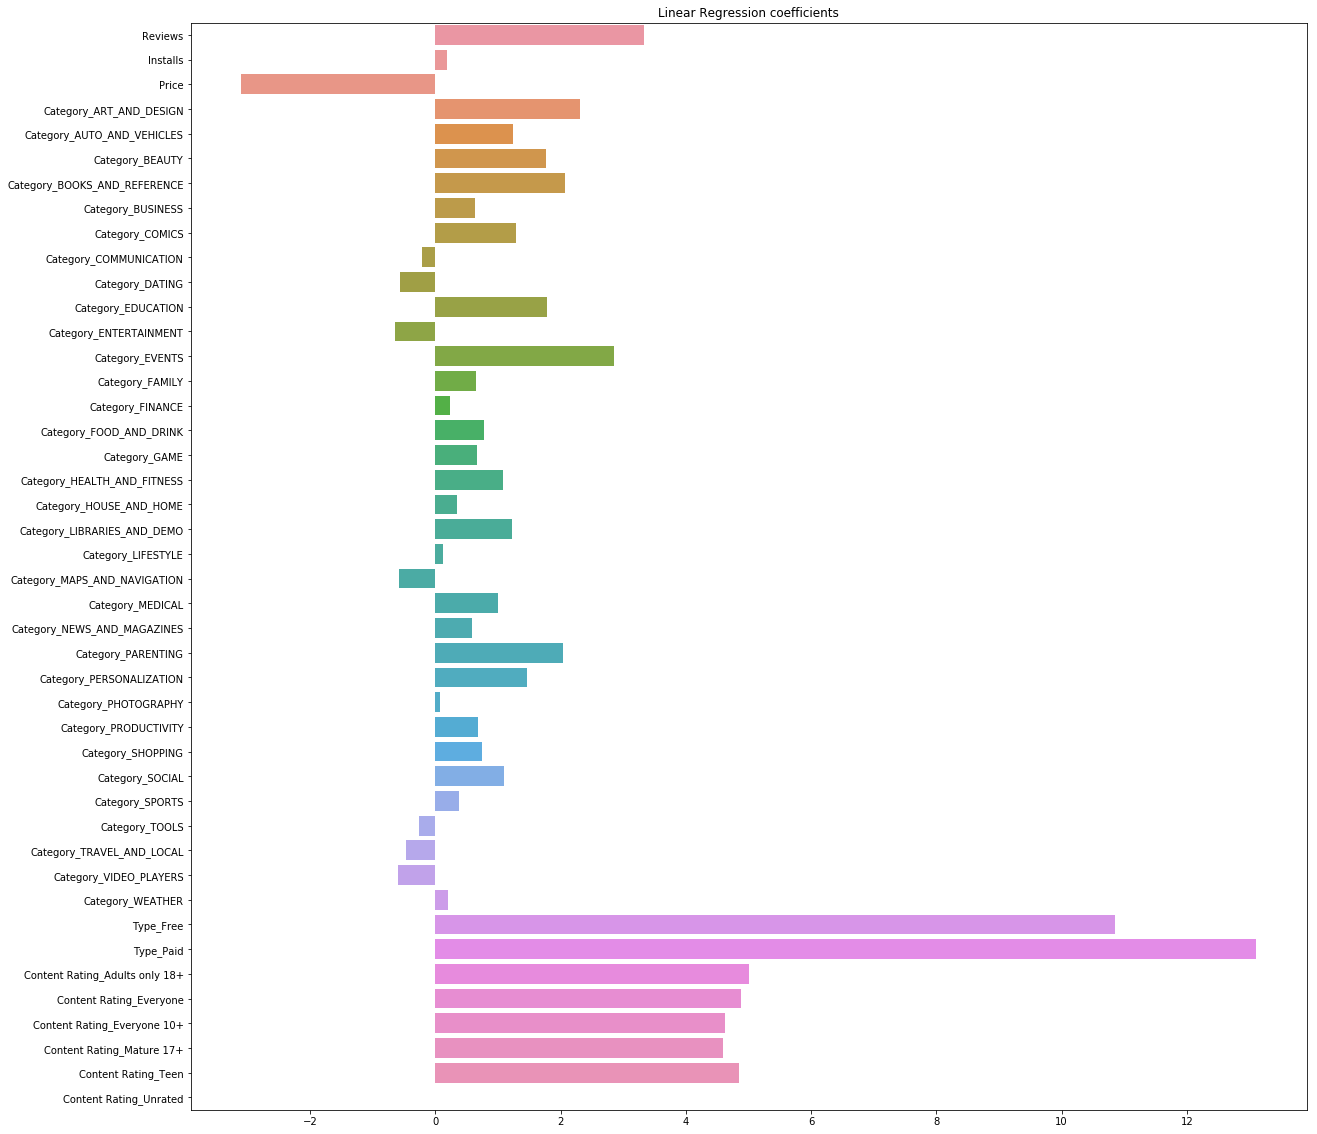

In [133]:
plt.figure(figsize = (20,20))
ax = plt.subplot(1,1,1)
sns.barplot(x=reg.coef_, y=encoded)
plt.title("Linear Regression coefficients")

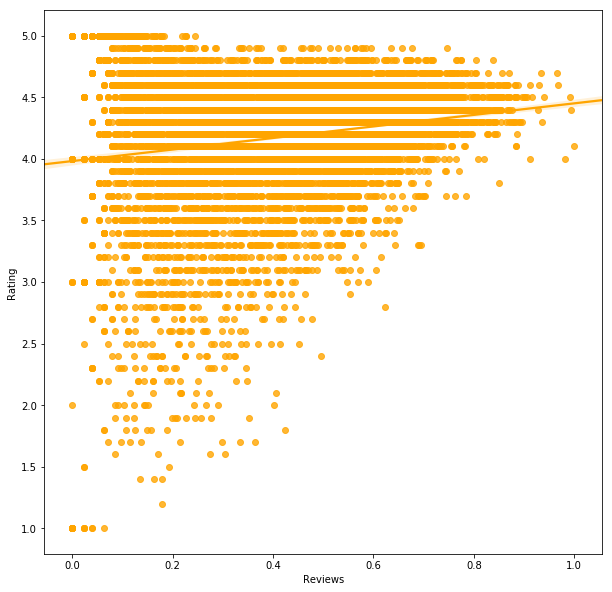

In [100]:
plt.figure(figsize = (10,10))
g = sns.regplot(x=features_final["Reviews"], y=rating,color = 'orange');

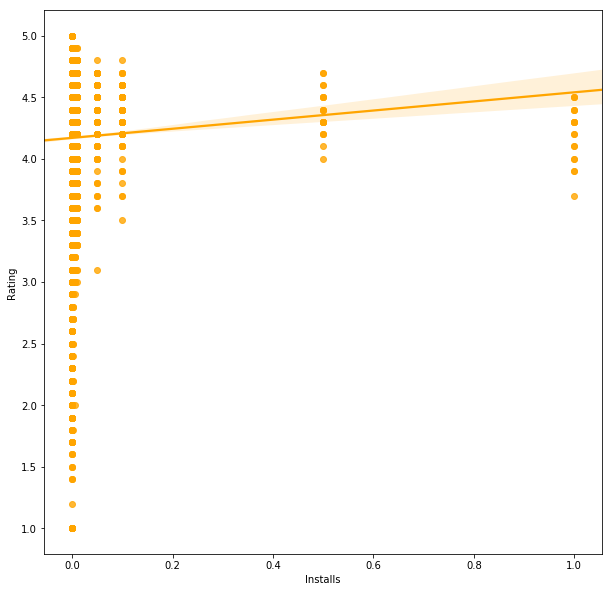

In [101]:
plt.figure(figsize = (10,10))
g = sns.regplot(x=features_final["Installs"], y=rating,color = 'orange');

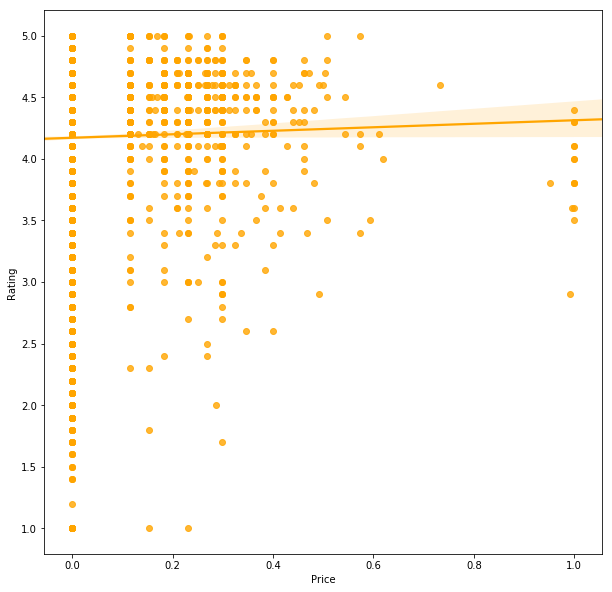

In [102]:
plt.figure(figsize = (10,10))
g = sns.regplot(x=features_final["Price"], y=rating,color = 'orange');

Text(0.5,1,'Boxplot of Rating VS Category')

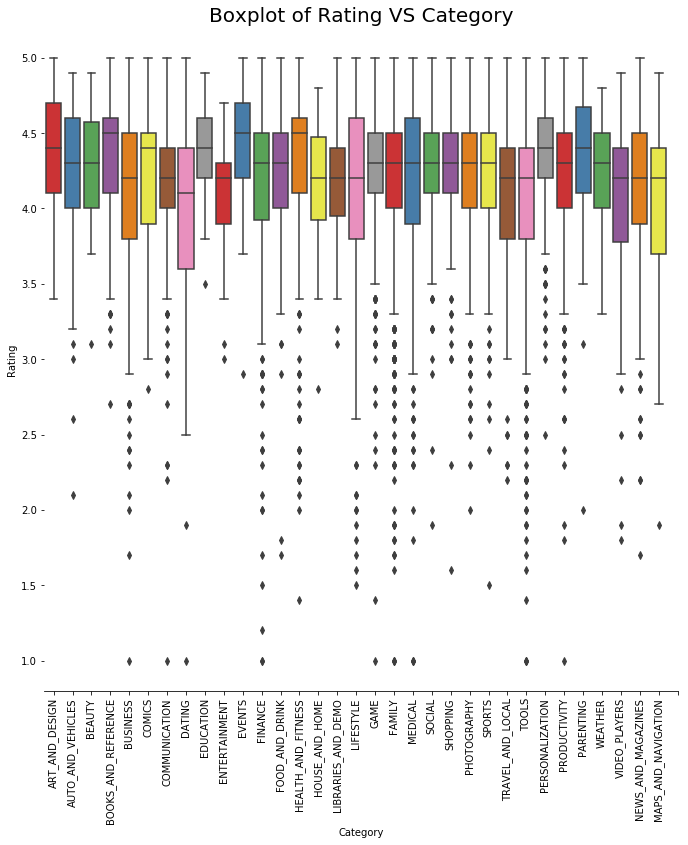

In [129]:
g = sns.catplot(x="Category",y=rating,data=features_raw, kind="box", height = 10 ,aspect = 2, palette = "Set1")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g.set( xticks=range(0,34))
g = g.set_ylabels("Rating")
plt.title('Rating VS Category',size = 20)

Text(0.5,1,'Rating VS Content Rating')

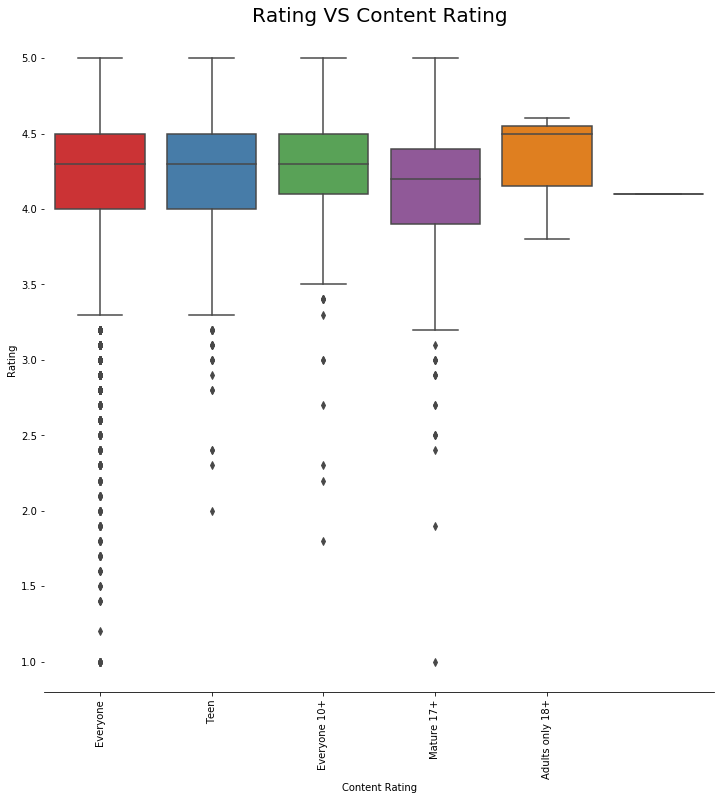

In [132]:
g = sns.catplot(x="Content Rating",y=rating,data=features_raw, kind="box", height = 10 ,aspect = 2, palette = "Set1")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g.set( xticks=range(0,5))
g = g.set_ylabels("Rating")
plt.title('Rating VS Content Rating',size = 20)